In [ ]:
# if MTA database already exisits, delete
import os

if os.path.exists('mta_data.db'):
    os.remove('mta_data.db')
    
# get MTA data from same year as satellite image
import get_mta

%run get_mta "17"


In [1]:
# import SQLAlchemy
from sqlalchemy import create_engine, inspect

# import data analysis, plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set default plot params
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['lines.linewidth'] = 2


In [2]:
# create SQL database engine
mta_data_engine = create_engine("sqlite:///mta_data.db")


In [3]:
def insert_table_from_csv(csv_list, engine):
    """
    Adds a .csv as a table in an SQL database
    """
    for file in csv_list:
        with open(file, 'r') as f:
            data = pd.read_csv(f)
            data.columns = data.columns.str.strip()
        data.to_sql(os.path.splitext(file)[0], con=engine, index=False, if_exists='replace')
    

In [6]:
# add the geocoded station locations as a table in the MTA database
insert_table_from_csv(['geocoded.csv'], mta_data_engine)


In [7]:
# make sure that the geocoded table was added
insp = inspect(mta_data_engine)
print('Tables in database:', insp.get_table_names())


Tables in database: ['geocoded', 'mta_data']


In [8]:
# rename column 'C/A' in the mta_data table to 'BOOTH' for consistency with the geocoded table
pd.read_sql('''
            ALTER TABLE mta_data 
            RENAME COLUMN "C/A" TO "BOOTH";
            ''',
            mta_data_engine);


OperationalError: (sqlite3.OperationalError) no such column: "C/A"
[SQL: 
            ALTER TABLE mta_data 
            RENAME COLUMN "C/A" TO "BOOTH";
            ]
(Background on this error at: http://sqlalche.me/e/14/e3q8)

In [9]:
# join mta_data and geocoded tables on the booth and unit numbers
# select turnstile-level information, include entries and exits, date, time, latitude, longitude
# add a flag 'LOC_FLAG' for booth/unit combinations that do not have latitude and longitude entries in the geocoded table
# keep only summer (June, July, August) data and 'REGULAR' scheduled audit events, not 'RECOVR AUD' entries to avoid duplicates
mta_df_read = pd.read_sql('''
            SELECT a.booth, a.unit, a.scp, a.station, a.linename, a.division,
              a.date, a.time,
              (a.date || ' ' || a.time) AS DATE_TIME,
              a.entries, a.exits,
              b.lat AS LAT, b.lon AS LON,
              (CASE
                WHEN b.lat IS NULL THEN 'True'
                ELSE 'False'
              END) AS LOC_FLAG
            FROM mta_data a
            LEFT JOIN geocoded b
            ON a.booth = b.booth AND a.unit = b.unit
            WHERE a.date >= '06/01/2017' 
              AND a.date <= '08/31/2017' 
              AND a.desc = 'REGULAR';
            ''', 
            mta_data_engine)


In [10]:
#TODO: delete in python script
mta_df_read.head()

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,08/26/2017 00:00:00,6303202,2133729,40.762796,-73.967686,False
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,08/26/2017 04:00:00,6303225,2133730,40.762796,-73.967686,False
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,08/26/2017 08:00:00,6303237,2133753,40.762796,-73.967686,False
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,08/26/2017 12:00:00,6303309,2133830,40.762796,-73.967686,False
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,08/26/2017 16:00:00,6303508,2133882,40.762796,-73.967686,False


In [11]:
#TODO: delete in python script
mta_df_read.dtypes

BOOTH         object
UNIT          object
SCP           object
STATION       object
LINENAME      object
DIVISION      object
DATE          object
TIME          object
DATE_TIME     object
ENTRIES        int64
EXITS          int64
LAT          float64
LON          float64
LOC_FLAG      object
dtype: object

In [12]:
#TODO: delete in python script
# check that no rows are duplicates
mta_df_read.groupby(['BOOTH', 'UNIT', 'SCP', 'STATION', 'DATE_TIME'], as_index=False).ENTRIES.count().sort_values('ENTRIES', ascending=False)


,BOOTH,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,06/01/2017 00:00:00,1
1729432,R147,R033,04-00-03,TIMES SQ-42 ST,06/15/2017 04:00:00,1
1729425,R147,R033,04-00-03,TIMES SQ-42 ST,06/14/2017 00:00:00,1
1729426,R147,R033,04-00-03,TIMES SQ-42 ST,06/14/2017 04:00:00,1
1729427,R147,R033,04-00-03,TIMES SQ-42 ST,06/14/2017 08:00:00,1
...,...,...,...,...,...,...
864713,N181A,R464,00-06-03,AQUEDUCT RACETR,07/12/2017 16:00:00,1
864714,N181A,R464,00-06-03,AQUEDUCT RACETR,07/12/2017 20:00:00,1
864715,N181A,R464,00-06-03,AQUEDUCT RACETR,07/13/2017 00:00:00,1
864716,N181A,R464,00-06-03,AQUEDUCT RACETR,07/13/2017 04:00:00,1


In [13]:
mta_df = mta_df_read.copy(deep=True)

# convert 'DATE_TIME' column to datetime format
mta_df['DATE_TIME'] = pd.to_datetime(mta_df.DATE_TIME, format = '%m/%d/%Y %H:%M:%S')

# convert 'LOC_FLAG' to boolean format
bools = {'True': True, 'False': False}
mta_df['LOC_FLAG'] = mta_df['LOC_FLAG'].map(bools)

# sort linenames
mta_df['LINENAME'] = mta_df['LINENAME'].apply(lambda x: ''.join(sorted(x)))


In [14]:
#TODO: delete in python script
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594142 entries, 0 to 2594141
Data columns (total 14 columns):
 #   Column     Dtype         
---  ------     -----         
 0   BOOTH      object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   DATE       object        
 7   TIME       object        
 8   DATE_TIME  datetime64[ns]
 9   ENTRIES    int64         
 10  EXITS      int64         
 11  LAT        float64       
 12  LON        float64       
 13  LOC_FLAG   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 259.8+ MB


In [15]:
mta_df.sort_values('DATE_TIME', ascending=True, inplace=True)


In [16]:
#TODO: delete in python script
mta_df

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG
2560904,N325A,R218,00-05-01,ELMHURST AV,MR,IND,06/01/2017,00:00:00,2017-06-01 00:00:00,100205,18616,40.742445,-73.882005,False
2582126,R244,R050,00-06-02,59 ST,456NQRW,IRT,06/01/2017,00:00:00,2017-06-01 00:00:00,4276512,850775,40.762796,-73.967686,False
2564430,N501A,R020,02-06-03,47-50 STS ROCK,BDFM,IND,06/01/2017,00:00:00,2017-06-01 00:00:00,104747,294722,40.758652,-73.981311,False
2591111,R604,R108,03-00-01,BOROUGH HALL,2345R,IRT,06/01/2017,00:00:00,2017-06-01 00:00:00,8137627,2314723,40.692404,-73.990151,False
2578661,R201,R041,00-00-01,BOWLING GREEN,45,IRT,06/01/2017,00:00:00,2017-06-01 00:00:00,1268678,731010,40.704782,-74.014099,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96599,PTH03,R552,00-01-06,JOURNAL SQUARE,1,PTH,08/31/2017,23:58:20,2017-08-31 23:58:20,29416,5536,40.732102,-74.063915,False
104279,PTH22,R540,02-00-00,PATH NEW WTC,1,PTH,08/31/2017,23:58:26,2017-08-31 23:58:26,34590,371606,40.711638,-74.010708,False
103262,PTH19,R549,02-01-06,NEWARK C,1,PTH,08/31/2017,23:58:36,2017-08-31 23:58:36,11128,1246,40.734595,-74.163987,False
101951,PTH17,R541,01-00-09,THIRTY THIRD ST,1,PTH,08/31/2017,23:59:25,2017-08-31 23:59:25,1270868,875089,40.748931,-73.988113,False


In [17]:
# new columns with the date, time of the previous measurement, and the number of new entries gained
mta_df[['PREV_DATE_TIME', 'PREV_ENTRIES']] = mta_df.groupby(['BOOTH', 'UNIT', 'SCP', 'STATION'])[['DATE_TIME', 'ENTRIES']].shift(1)


In [18]:
#TODO: delete in python script
mta_df

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG,PREV_DATE_TIME,PREV_ENTRIES
2560904,N325A,R218,00-05-01,ELMHURST AV,MR,IND,06/01/2017,00:00:00,2017-06-01 00:00:00,100205,18616,40.742445,-73.882005,False,NaT,NaN
2582126,R244,R050,00-06-02,59 ST,456NQRW,IRT,06/01/2017,00:00:00,2017-06-01 00:00:00,4276512,850775,40.762796,-73.967686,False,NaT,NaN
2564430,N501A,R020,02-06-03,47-50 STS ROCK,BDFM,IND,06/01/2017,00:00:00,2017-06-01 00:00:00,104747,294722,40.758652,-73.981311,False,NaT,NaN
2591111,R604,R108,03-00-01,BOROUGH HALL,2345R,IRT,06/01/2017,00:00:00,2017-06-01 00:00:00,8137627,2314723,40.692404,-73.990151,False,NaT,NaN
2578661,R201,R041,00-00-01,BOWLING GREEN,45,IRT,06/01/2017,00:00:00,2017-06-01 00:00:00,1268678,731010,40.704782,-74.014099,False,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96599,PTH03,R552,00-01-06,JOURNAL SQUARE,1,PTH,08/31/2017,23:58:20,2017-08-31 23:58:20,29416,5536,40.732102,-74.063915,False,2017-08-31 19:46:20,29373.0
104279,PTH22,R540,02-00-00,PATH NEW WTC,1,PTH,08/31/2017,23:58:26,2017-08-31 23:58:26,34590,371606,40.711638,-74.010708,False,2017-08-31 19:46:26,34562.0
103262,PTH19,R549,02-01-06,NEWARK C,1,PTH,08/31/2017,23:58:36,2017-08-31 23:58:36,11128,1246,40.734595,-74.163987,False,2017-08-31 19:46:36,11126.0
101951,PTH17,R541,01-00-09,THIRTY THIRD ST,1,PTH,08/31/2017,23:59:25,2017-08-31 23:59:25,1270868,875089,40.748931,-73.988113,False,2017-08-31 19:47:25,1270511.0


In [19]:
# drop the rows for the first measurement in the df because there is no 'PREV_DATE_TIME', and reset the index
mta_df.dropna(subset=['PREV_DATE_TIME'], axis=0, inplace=True)
mta_df.reset_index(drop=True, inplace=True)


In [20]:
#TODO: delete in python script
mta_df

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG,PREV_DATE_TIME,PREV_ENTRIES
0,R246,R177,00-03-05,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,2792397,2629643,40.768143,-73.964016,False,2017-06-01 01:00:00,2792392.0
1,R246,R177,00-00-04,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,4497745,2695096,40.768143,-73.964016,False,2017-06-01 01:00:00,4497743.0
2,R246,R177,00-00-01,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,363598,145046,40.768143,-73.964016,False,2017-06-01 01:00:00,363594.0
3,R246,R177,00-00-06,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,902565,561613,40.768143,-73.964016,False,2017-06-01 01:00:00,902564.0
4,R246,R177,00-03-04,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,8064828,6870238,40.768143,-73.964016,False,2017-06-01 01:00:00,8064817.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589418,PTH03,R552,00-01-06,JOURNAL SQUARE,1,PTH,08/31/2017,23:58:20,2017-08-31 23:58:20,29416,5536,40.732102,-74.063915,False,2017-08-31 19:46:20,29373.0
2589419,PTH22,R540,02-00-00,PATH NEW WTC,1,PTH,08/31/2017,23:58:26,2017-08-31 23:58:26,34590,371606,40.711638,-74.010708,False,2017-08-31 19:46:26,34562.0
2589420,PTH19,R549,02-01-06,NEWARK C,1,PTH,08/31/2017,23:58:36,2017-08-31 23:58:36,11128,1246,40.734595,-74.163987,False,2017-08-31 19:46:36,11126.0
2589421,PTH17,R541,01-00-09,THIRTY THIRD ST,1,PTH,08/31/2017,23:59:25,2017-08-31 23:59:25,1270868,875089,40.748931,-73.988113,False,2017-08-31 19:47:25,1270511.0


In [21]:
# calculate the amount of time (in seconds) between measurements
mta_df['DELTA_DATE_TIME_SEC'] = np.abs(mta_df['DATE_TIME'] - mta_df['PREV_DATE_TIME']) / pd.Timedelta(seconds=1)


In [22]:
#TODO: delete in python script
mta_df

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG,PREV_DATE_TIME,PREV_ENTRIES,DELTA_DATE_TIME_SEC
0,R246,R177,00-03-05,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,2792397,2629643,40.768143,-73.964016,False,2017-06-01 01:00:00,2792392.0,10367.0
1,R246,R177,00-00-04,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,4497745,2695096,40.768143,-73.964016,False,2017-06-01 01:00:00,4497743.0,10367.0
2,R246,R177,00-00-01,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,363598,145046,40.768143,-73.964016,False,2017-06-01 01:00:00,363594.0,10367.0
3,R246,R177,00-00-06,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,902565,561613,40.768143,-73.964016,False,2017-06-01 01:00:00,902564.0,10367.0
4,R246,R177,00-03-04,68ST-HUNTER CO,6,IRT,06/01/2017,03:52:47,2017-06-01 03:52:47,8064828,6870238,40.768143,-73.964016,False,2017-06-01 01:00:00,8064817.0,10367.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589418,PTH03,R552,00-01-06,JOURNAL SQUARE,1,PTH,08/31/2017,23:58:20,2017-08-31 23:58:20,29416,5536,40.732102,-74.063915,False,2017-08-31 19:46:20,29373.0,15120.0
2589419,PTH22,R540,02-00-00,PATH NEW WTC,1,PTH,08/31/2017,23:58:26,2017-08-31 23:58:26,34590,371606,40.711638,-74.010708,False,2017-08-31 19:46:26,34562.0,15120.0
2589420,PTH19,R549,02-01-06,NEWARK C,1,PTH,08/31/2017,23:58:36,2017-08-31 23:58:36,11128,1246,40.734595,-74.163987,False,2017-08-31 19:46:36,11126.0,15120.0
2589421,PTH17,R541,01-00-09,THIRTY THIRD ST,1,PTH,08/31/2017,23:59:25,2017-08-31 23:59:25,1270868,875089,40.748931,-73.988113,False,2017-08-31 19:47:25,1270511.0,15120.0


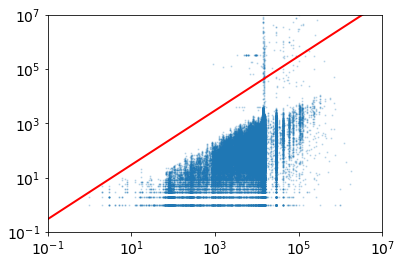

In [23]:
#TODO: delete in python script
plt.scatter(mta_df['DELTA_DATE_TIME_SEC'], np.abs(mta_df['ENTRIES'] - mta_df['PREV_ENTRIES']), s=1, alpha=0.2)
plt.xscale('log')
plt.yscale('log')

plt.xlim(0.1,1e7)
plt.ylim(0.1,1e7)

x = np.arange(0.1,1e7,10000)
y = x*3
plt.plot(x,y,color='r')


In [24]:
#TODO: delete in python script
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589423 entries, 0 to 2589422
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   BOOTH                object        
 1   UNIT                 object        
 2   SCP                  object        
 3   STATION              object        
 4   LINENAME             object        
 5   DIVISION             object        
 6   DATE                 object        
 7   TIME                 object        
 8   DATE_TIME            datetime64[ns]
 9   ENTRIES              int64         
 10  EXITS                int64         
 11  LAT                  float64       
 12  LON                  float64       
 13  LOC_FLAG             bool          
 14  PREV_DATE_TIME       datetime64[ns]
 15  PREV_ENTRIES         float64       
 16  DELTA_DATE_TIME_SEC  float64       
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2), object(8)
memory usage: 318.6+ MB


In [25]:
# to deal with turnstiles that are counting in reverse, always take the absolute value of the difference between current entries and previous entries
# for hourly entries that are very high, as an upper limit, use 3 people per turnstile per second 
pps = 3
mta_df['HOURLY_ENTRIES'] = [np.abs(entries - mta_df['PREV_ENTRIES'][i]) \
                            if (np.abs(entries - mta_df['PREV_ENTRIES'][i]) < pps*mta_df['DELTA_DATE_TIME_SEC'][i]) \
                            else (pps*mta_df['DELTA_DATE_TIME_SEC'][i]) \
                            for i,entries in enumerate(mta_df['ENTRIES'])]


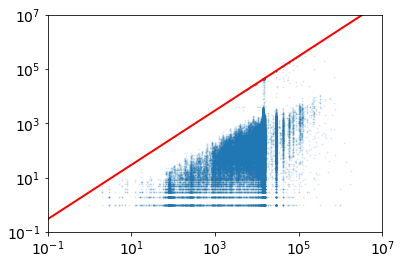

In [26]:
#TODO: delete in python script
plt.scatter(mta_df['DELTA_DATE_TIME_SEC'], mta_df['HOURLY_ENTRIES'], s=1, alpha=0.1)
plt.xscale('log')
plt.yscale('log')

plt.xlim(0.1,1e7)
plt.ylim(0.1,1e7)

x = np.arange(0.1,1e7,10000)
y = x*3
plt.plot(x,y,color='r')


In [ ]:
#TODO: delete
print(len(mta_df.groupby(['STATION','LINENAME'], as_index=False)))
for i, group in mta_df.groupby(['STATION','LINENAME'], as_index=False):
    print(i)
    

In [36]:
# group unique stations (some stations have the same name, but are on different lines)
# sum the hourly entries to get the total number of entries over the time period
station_df = mta_df.groupby(['STATION','LINENAME'], as_index=False).agg({'DIVISION':'first', 'LAT':'first', 'LON':'first', 'LOC_FLAG':'first', 'HOURLY_ENTRIES':'sum'}).sort_values('HOURLY_ENTRIES', ascending=False)

# rename the 'HOURLY_ENTRIES' column to 'NET_ENTRIES'
station_df.rename(columns={'HOURLY_ENTRIES': 'NET_ENTRIES'}, inplace=True)

# reset index so that index corresponds to ranked net entries
station_df.reset_index(drop=True, inplace=True)


In [39]:
station_df.head(10)

,STATION,LINENAME,DIVISION,LAT,LON,LOC_FLAG,NET_ENTRIES
0,GRD CNTRL-42 ST,4567S,IRT,40.751849,-73.976945,False,11561767.0
1,34 ST-HERALD SQ,BDFMNQRW,IND,40.749533,-73.987899,False,10456578.0
2,14 ST-UNION SQ,456LNQRW,BMT,40.734836,-73.990688,False,8841256.0
3,42 ST-PORT AUTH,1237ACENQRSW,IND,40.757303,-73.989787,False,7264859.0
4,FULTON ST,2345ACJZ,IND,40.709938,-74.007983,False,7051085.0
5,TIMES SQ-42 ST,1237ACENQRSW,BMT,40.755905,-73.986504,False,6724058.0
6,34 ST-PENN STA,ACE,IND,40.752247,-73.993456,False,6598510.0
7,59 ST COLUMBUS,1ABCD,IND,40.768110,-73.981891,False,5529401.0
8,PATH NEW WTC,1,PTH,40.711638,-74.010708,False,4998891.0
9,FLUSHING-MAIN,7,IRT,40.759578,-73.830056,False,4811178.0


In [38]:
# check that all stations (except a few PATH stations) have lat, lon coordinates
station_df[station_df['LOC_FLAG'] == True]

,STATION,LINENAME,DIVISION,LAT,LON,LOC_FLAG,NET_ENTRIES
29,CITY / BUS,1,PTH,NaN,NaN,True,2760348.0
46,NEWARK BM BW,1,PTH,NaN,NaN,True,2035857.0
159,THIRTY ST,1,PTH,NaN,NaN,True,977311.0
161,NEWARK HW BMEBE,1,PTH,NaN,NaN,True,967032.0
412,NEWARK HM HE,1,PTH,NaN,NaN,True,223570.0


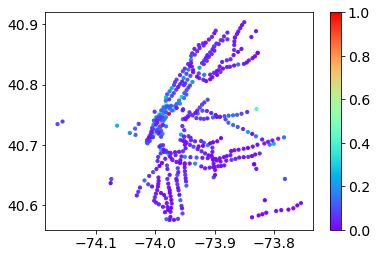

In [81]:
plt.scatter(station_df['LON'], station_df['LAT'],
            c=((station_df['NET_ENTRIES']-np.min(station_df['NET_ENTRIES']))/(np.max(station_df['NET_ENTRIES'])-np.min(station_df['NET_ENTRIES']))), 
            s=10, cmap='rainbow')
plt.colorbar()


In [68]:
min_entries = np.min(station_df['NET_ENTRIES'])
max_entries = np.max(station_df['NET_ENTRIES'])

station_df['CROWD_INDEX'] = station_df['NET_ENTRIES'].apply(lambda x: 10.0 * np.log10(x/min_entries) / np.log10(max_entries/min_entries))


In [69]:
station_df

,STATION,LINENAME,DIVISION,LAT,LON,LOC_FLAG,NET_ENTRIES,CROWD_INDEX
0,GRD CNTRL-42 ST,4567S,IRT,40.751849,-73.976945,False,11561767.0,10.000000
1,34 ST-HERALD SQ,BDFMNQRW,IND,40.749533,-73.987899,False,10456578.0,9.849844
2,14 ST-UNION SQ,456LNQRW,BMT,40.734836,-73.990688,False,8841256.0,9.599065
3,42 ST-PORT AUTH,1237ACENQRSW,IND,40.757303,-73.989787,False,7264859.0,9.305575
4,FULTON ST,2345ACJZ,IND,40.709938,-74.007983,False,7051085.0,9.260939
...,...,...,...,...,...,...,...,...
461,BEACH 105 ST,AS,IND,40.583542,-73.826430,False,40790.0,1.560551
462,BAY PKWY,F,IND,40.620907,-73.975453,False,33398.0,1.261740
463,BROAD CHANNEL,AS,IND,40.608693,-73.816068,False,24037.0,0.770198
464,ORCHARD BEACH,6,IND,40.852417,-73.828082,False,21401.0,0.596603


<AxesSubplot:>

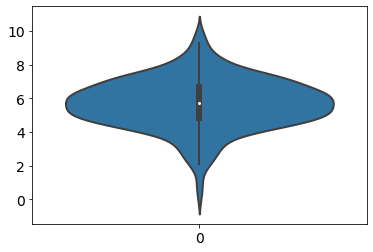

In [76]:
import seaborn as sns

sns.violinplot(data=station_df['CROWD_INDEX'])

<AxesSubplot:>

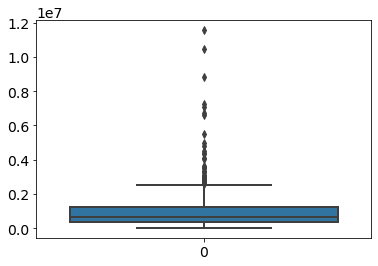

In [75]:
sns.boxplot(data=station_df['NET_ENTRIES'])